In [5]:
from exp.expdata import GenExAdapter
import matplotlib.pyplot as plt
import numpy as np

from pysindy import STLSQ

from exp.evaluate.jsindy import evaluate_jmodel
from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant, CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings, AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


In [17]:
noise = 0.1
dt_train = 2.0
t1=100.

expdata = GenExAdapter(
    system="vdp",
    t0=0.,
    ic_std=0.02,
    t1=t1,
    noise=noise,
    n_train=50,
    n_colloc=500,
    seed=1234
)

In [18]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train
t_train.shape
(100,)

(100,)

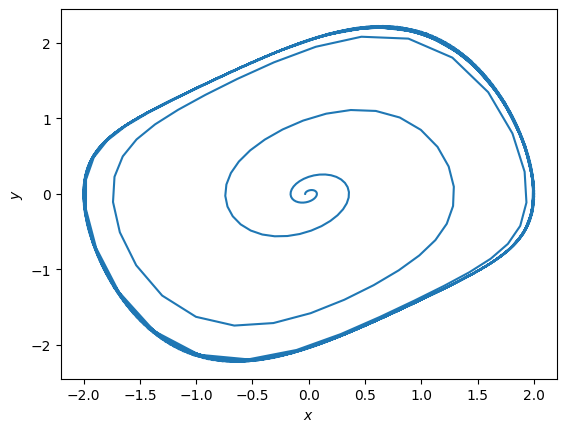

In [19]:
plt.plot(x_true[:,0], x_true[:,1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

# Learn Model

## Let jsindy handle 2nd order

In [20]:
kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=2.0)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=3)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 1e5
sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 0.1))
optimizer = AnnealedAlternatingActiveSetLMSolver(
    beta_reg=1e-5,
    solver_settings=optsettings,
    fixed_colloc_weight=colloc_weight,
    fixed_data_weight=data_weight,
    sparsifier = sparsifier,
    num_annealing_steps=3,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    input_orders=(0, 1),
    ode_order=2,
    feature_names=['x']
)

In [21]:
model.fit(expdata.t_train, expdata.x_train[:, :1], expdata.t_colloc)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.12054914e-08, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 100000.0}
Solving for data_weight = 20.0, colloc_weight = 4000.0 beta_reg = 4e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 7.718, gradnorm = 122.0, alpha = 4.167, improvement_ratio = 1.011
Iteration 1, loss = 6.477, gradnorm = 72.06, alpha = 3.472, improvement_ratio = 1.033
Iteration 2, loss = 6.34, gradnorm = 21.81, alpha = 2.894, improvement_ratio = 1.081
Iteration 3, loss = 6.29, gradnorm = 1.232, alpha = 2.411, improvement_ratio = 1.011
Iteration 4, loss = 6.243, gradnorm = 0.532, alpha = 2.009, improvement_ratio = 1.004
Iteration 5, loss = 6.19, gradnorm = 0.4816, alpha = 1.674, improvement_ratio = 1.005
Line Search Failed!
Final Iteration Results
Iteration 77, loss = 3.771, gradnorm = 1.359e-07, alpha = 0.01596, improvement_ratio = -7.56e+03
Solving for data_weight = 20.0, colloc_weight = 20000.0 beta_reg = 2e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.715, gradnorm = 89.61, alpha = 4.167, improvement_ratio = 0.9963
Iteration 1, loss = 5.499, gradnorm = 5.697, alpha = 3.472, improvement_ratio = 1.013
Iteration 2, loss = 5.359, gradnorm = 2.698, alpha = 2.894, improvement_ratio = 1.006
Iteration 3, loss = 5.25, gradnorm = 1.647, alpha = 2.411, improvement_ratio = 1.004
Iteration 4, loss = 5.161, gradnorm = 1.265, alpha = 2.009, improvement_ratio = 1.003
Iteration 5, loss = 5.087, gradnorm = 1.049, alpha = 1.674, improvement_ratio = 1.003
Iteration 100, loss = 4.726, gradnorm = 5.092e-08, alpha = 72.34, improvement_ratio = 9.261e+03
Solving for data_weight = 20.0, colloc_weight = 100000.0 beta_reg = 1e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 5.222, gradnorm = 110.9, alpha = 4.167, improvement_ratio = 1.001
Iteration 1, loss = 5.135, gradnorm = 2.71, alpha = 3.472, improvement_ratio = 1.002
Iteration 2, loss = 5.093, gradnorm = 0.8747, alpha = 2.894, improvement_ratio = 1.001
Iteration 3, loss = 5.068, gradnorm = 0.4644, alpha = 2.411, improvement_ratio = 1.001
Iteration 4, loss = 5.052, gradnorm = 0.3165, alpha = 2.009, improvement_ratio = 1.001
Iteration 5, loss = 5.04, gradnorm = 0.2307, alpha = 1.674, improvement_ratio = 1.001
Line Search Failed!
Final Iteration Results
Iteration 75, loss = 5.006, gradnorm = 4.076e-07, alpha = 1.06, improvement_ratio = -inf
Model after smooth warm start
(x)'' = -0.007 1 + -1.016 x + 0.478 (x') + -0.012 x^2 + -0.010 x (x') + 0.008 (x')^2 + -0.005 x^3 + -0.538 x^2 (x') + 0.013 x (x')^2 + 0.018 (x')^3
Alternating Activeset Sparsifier
7 active coeffs changed
Active set stabilized


In [22]:
x_pred = model.predict_state(expdata.t_true)
xdot_pred = model.traj_model.derivative(expdata.t_true,model.z,diff_order = 1)

x_true = expdata.x_true
model.print()

(x)'' = -1.001 x + 0.502 (x') + -0.502 x^2 (x')


In [15]:
expdata.print()

x' = 1 x'
x'' = -1 x + 0.5 x' + -0.5 x^2 x'


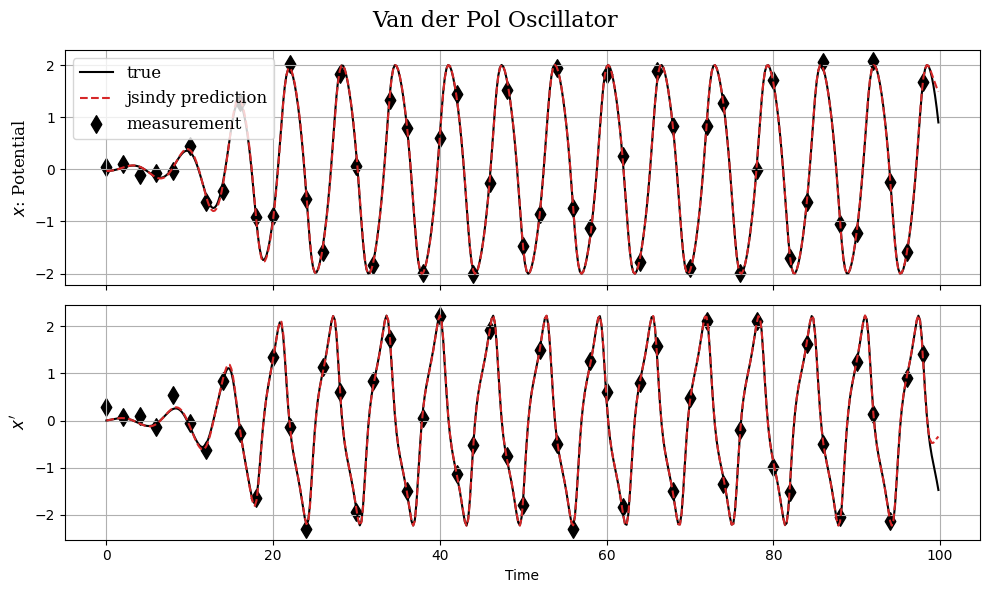

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="true", c='black',)
ax1.plot(t_true, x_pred, label='jsindy prediction',linestyle='--',c='tab:red')
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80,c='black')
ax1.set_ylabel(r"$x$: Potential", fontname=fontname,size=12)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='black')
ax2.plot(t_true, xdot_pred, label='prediction', linestyle='--', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='black', marker='d',s=80)
ax2.set_ylabel(r"$x'$", fontname=fontname,size=12)
ax2.set_xlabel("Time")
ax2.grid(True)
# ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Van der Pol Oscillator", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()